In [1]:
#!pip install opencv-python
#!pip install -U scikit-learn
#!conda update -n base -c conda-forge conda

In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
import cv2
import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
from random import shuffle
from sklearn.model_selection import train_test_split


Number of benign images: 437
Number of benign masks: 437
Number of malignant images: 210
Number of malignant masks: 210
Image name: benign (298).png
Mask name: benign (298)_mask.png


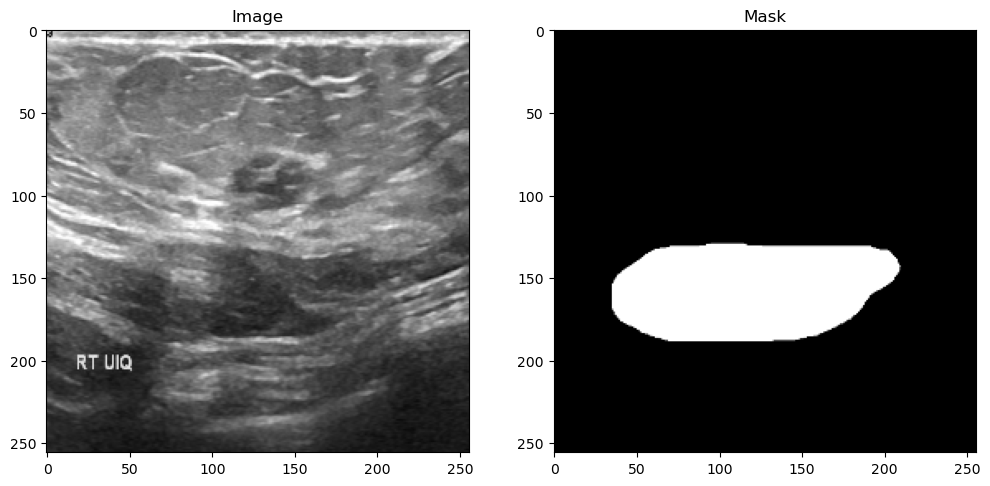

In [3]:
data_path = "/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT"

# load the images and masks for the benign and malignant folders
benign_images = []
benign_masks = []
malignant_images = []
malignant_masks = []

for folder in ["benign", "malignant"]:
    filenames = os.listdir(os.path.join(data_path, folder))
    filenames.sort()  # sort the filenames alphabetically
    for filename in filenames:
        if "_mask.png" in filename and "_mask_1.png" not in filename:
            # load the mask and resize it to (256, 256)
            mask = cv2.imread(os.path.join(data_path, folder, filename), 0)
            mask = cv2.resize(mask, (256, 256))
            benign_masks.append(mask) if folder == "benign" else malignant_masks.append(mask)
        elif ".png" in filename and "_mask_" not in filename:
            # load the image and resize it to (256, 256)
            img = cv2.imread(os.path.join(data_path, folder, filename))
            img = cv2.resize(img, (256, 256))
            benign_images.append(img) if folder == "benign" else malignant_images.append(img)

# check that each image has a corresponding mask and vice versa
assert len(benign_images) == len(benign_masks)
assert len(malignant_images) == len(malignant_masks)

# print the size of the image and mask lists
print("Number of benign images:", len(benign_images))
print("Number of benign masks:", len(benign_masks))
print("Number of malignant images:", len(malignant_images))
print("Number of malignant masks:", len(malignant_masks))

# display a random example from the benign images and masks
idx = random.randint(0, len(benign_images)-1)
img = benign_images[idx]
mask = benign_masks[idx]

# print the filenames of the image and mask being displayed
img_name = os.path.basename(os.path.join(data_path, "benign", f"benign ({idx+1}).png"))
mask_name = os.path.basename(os.path.join(data_path, "benign", f"benign ({idx+1})_mask.png"))
print("Image name:", img_name)
print("Mask name:", mask_name)

# create the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')

# show the plot
plt.show()


In [4]:
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # convert to grayscale
        normalized = (image - np.min(image)) / (np.max(image) - np.min(image))  # normalize pixel values
        normalized = np.expand_dims(normalized, axis=-1)  # add channel dimension
        preprocessed_images.append(normalized)
    return preprocessed_images

# preprocess the benign and malignant images and masks
benign_images = preprocess_images(benign_images)
benign_masks = preprocess_images(benign_masks)
malignant_images = preprocess_images(malignant_images)
malignant_masks = preprocess_images(malignant_masks)

In [5]:
def dice_coeff(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [6]:
def unet(input_shape):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.8)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Expansive path
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8],axis=3)

    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    up9 = UpSampling2D(size=(2, 2))(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [7]:
# Combine benign and malignant images and masks into one dataset
images_dataset = list(zip(benign_images + malignant_images, benign_masks + malignant_masks))

# Shuffle the dataset
shuffle(images_dataset)

# Split data into training and testing sets
train_val_images, test_images, train_val_masks, test_masks = train_test_split(images_dataset, images_dataset, test_size=0.2, random_state=42)

# Split training data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_val_images, train_val_masks, test_size=0.2, random_state=42)

print("Number of training images:", len(train_images))
print("Number of validation images:", len(val_images))
print("Number of testing images:", len(test_images))
print("Number of training masks:", len(train_masks))
print("Number of validation masks:", len(val_masks))
print("Number of testing masks:", len(test_masks))

Number of training images: 413
Number of validation images: 104
Number of testing images: 130
Number of training masks: 413
Number of validation masks: 104
Number of testing masks: 130


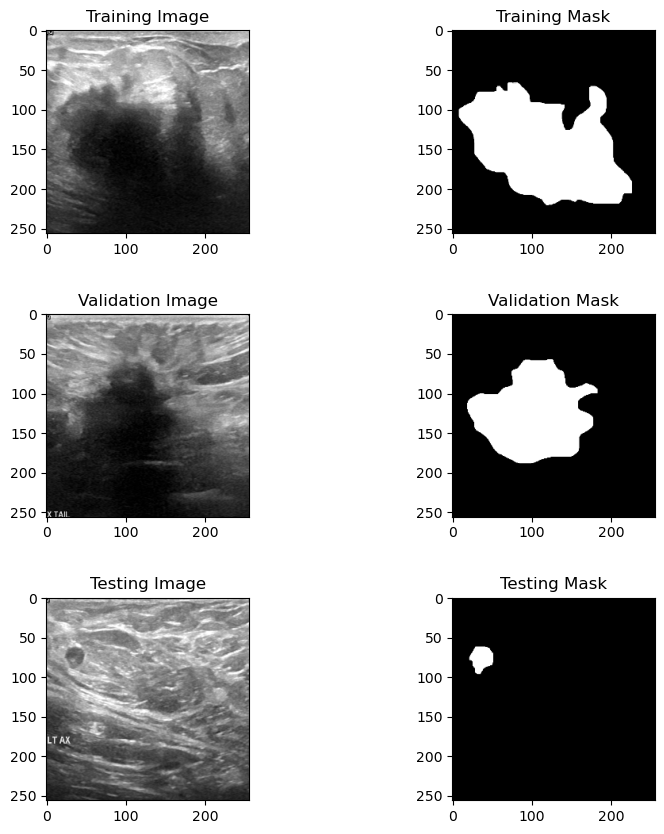

In [8]:
# Define the figure and subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

# Define lists of images and masks for each dataset
train_images, train_masks = zip(*train_images)
val_images, val_masks = zip(*val_images)
test_images, test_masks = zip(*test_images)

# Get a random index for each dataset
train_index = random.randint(0, len(train_images)-1)
val_index = random.randint(0, len(val_images)-1)
test_index = random.randint(0, len(test_images)-1)

# Get the corresponding images and masks
train_img = train_images[train_index].squeeze()
val_img = val_images[val_index].squeeze()
test_img = test_images[test_index].squeeze()

train_mask = train_masks[train_index]
val_mask = val_masks[val_index]
test_mask = test_masks[test_index]

# Plot the images and masks
axs[0, 0].imshow(train_img, cmap='gray')
axs[0, 0].set_title('Training Image')
axs[0, 1].imshow(train_mask, cmap='gray')
axs[0, 1].set_title('Training Mask')

axs[1, 0].imshow(val_img, cmap='gray')
axs[1, 0].set_title('Validation Image')
axs[1, 1].imshow(val_mask, cmap='gray')
axs[1, 1].set_title('Validation Mask')

axs[2, 0].imshow(test_img, cmap='gray')
axs[2, 0].set_title('Testing Image')
axs[2, 1].imshow(test_mask, cmap='gray')
axs[2, 1].set_title('Testing Mask')

# Show the plot
plt.show()

In [9]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(413, 256, 256, 1)
(413, 256, 256, 1)
(104, 256, 256, 1)
(104, 256, 256, 1)
(130, 256, 256, 1)
(130, 256, 256, 1)


In [10]:
input_shape = (None, None, 1)
model = unet(input_shape)
model.compile(optimizer=Adam(lr=1e-4), loss=dice_loss, metrics=[dice_coeff])

# Define early stopping callback
early_stop = EarlyStopping(patience=15, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks),
                    batch_size=16, epochs=100, callbacks=[early_stop])

Metal device set to: Apple M1 Max
Epoch 1/100


/Users/syn/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-04-21 14:56:53.771781: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


26/26 [==============================] - 38s 1s/step - loss: 0.8502 - dice_coeff: 0.1501 - val_loss: 0.8343 - val_dice_coeff: 0.1683
Epoch 2/100
26/26 [==============================] - 37s 1s/step - loss: 0.8389 - dice_coeff: 0.1615 - val_loss: 0.8153 - val_dice_coeff: 0.1873
Epoch 3/100
26/26 [==============================] - 37s 1s/step - loss: 0.7831 - dice_coeff: 0.2170 - val_loss: 0.7649 - val_dice_coeff: 0.2427
Epoch 4/100
26/26 [==============================] - 37s 1s/step - loss: 0.6958 - dice_coeff: 0.3044 - val_loss: 0.6822 - val_dice_coeff: 0.3253
Epoch 5/100
26/26 [==============================] - 37s 1s/step - loss: 0.6918 - dice_coeff: 0.3080 - val_loss: 0.7089 - val_dice_coeff: 0.2986
Epoch 6/100
26/26 [==============================] - 37s 1s/step - loss: 0.6444 - dice_coeff: 0.3548 - val_loss: 0.6438 - val_dice_coeff: 0.3621
Epoch 7/100
26/26 [==============================] - 37s 1s/step - loss: 0.6147 - dice_coeff: 0.3855 - val_loss: 0.6361 - val_dice_coeff: 0.36

In [11]:
test_loss, test_dice_coef = model.evaluate(test_images, test_masks)
print(f'Test loss: {test_loss}')
print(f'Test Dice coefficient: {test_dice_coef}')

5/5 [==============================] - 3s 496ms/step - loss: 0.3103 - dice_coeff: 0.6990
Test loss: 0.31027644872665405
Test Dice coefficient: 0.6990434527397156


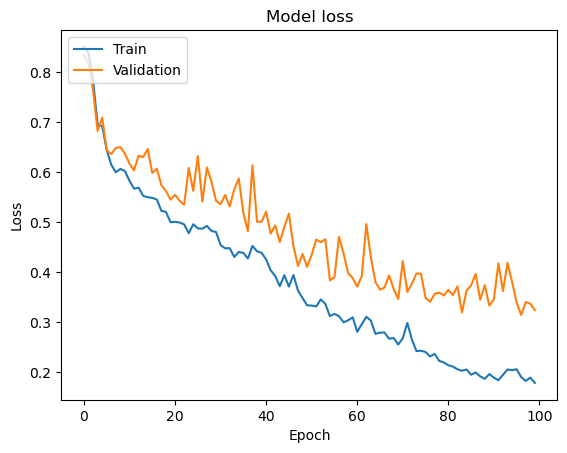

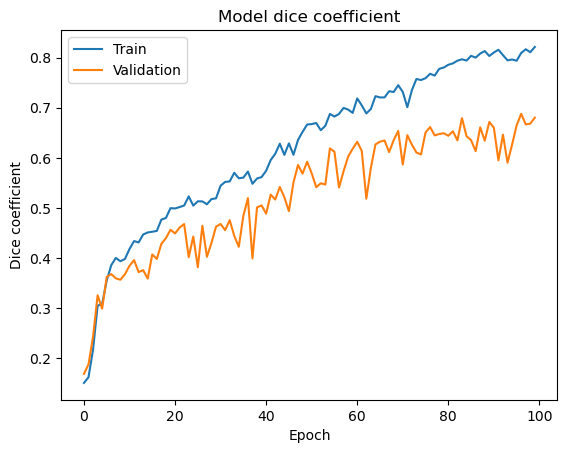

In [12]:
# Extract training and validation loss values from results
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract training and validation dice coefficient values from results
train_dice_coeff = history.history['dice_coeff']
val_dice_coeff = history.history['val_dice_coeff']

# Plot training and validation loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation dice coefficient
plt.plot(train_dice_coeff)
plt.plot(val_dice_coeff)
plt.title('Model dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# generate predicted masks using the loaded model and the preprocessed test images
predicted_masks = model.predict(test_images)
model.save_weights('my_model_weights.h5')

5/5 [==============================] - 3s 499ms/step


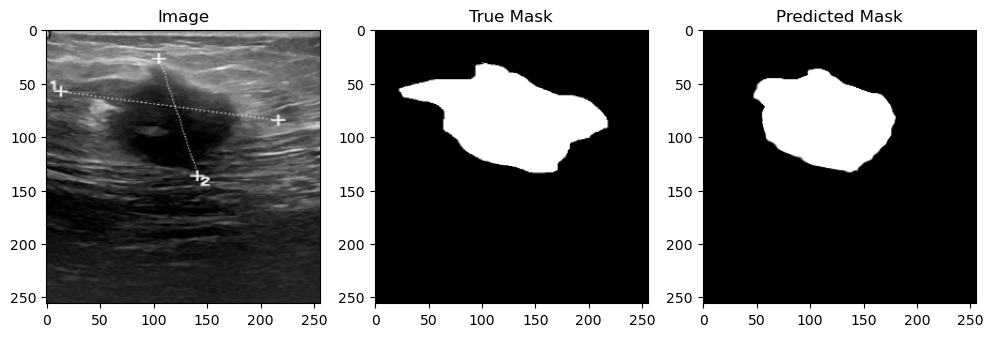

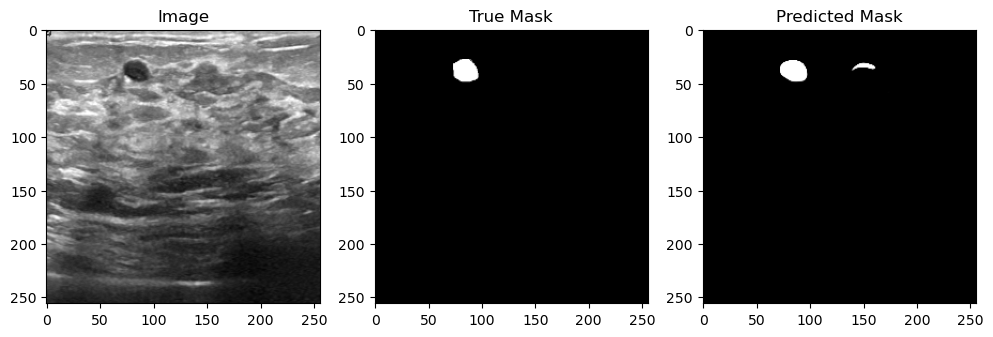

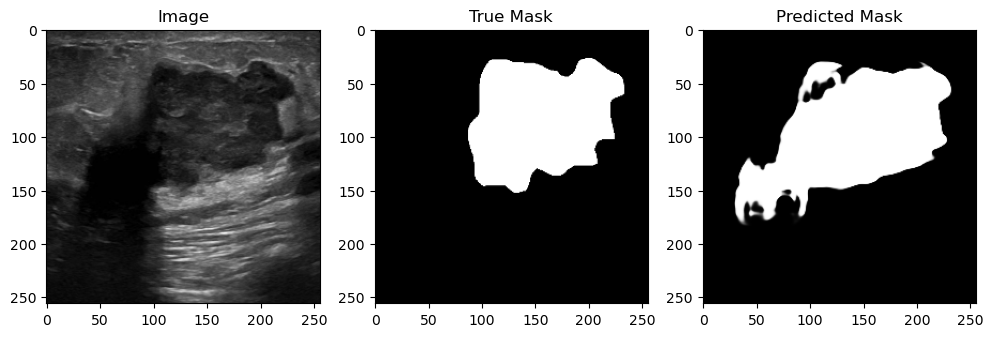

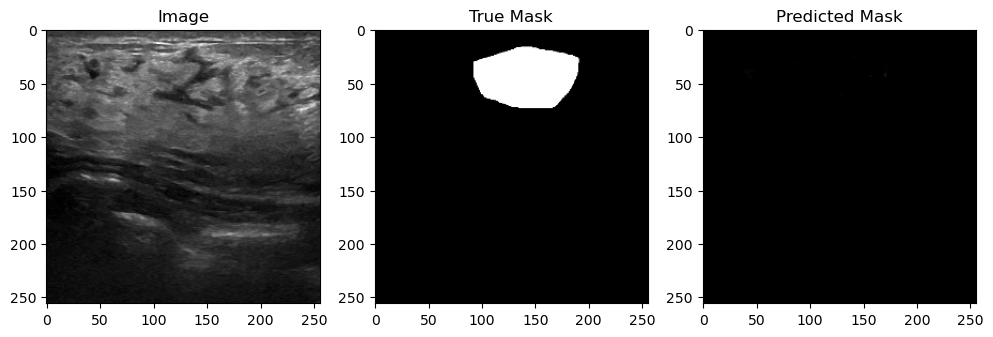

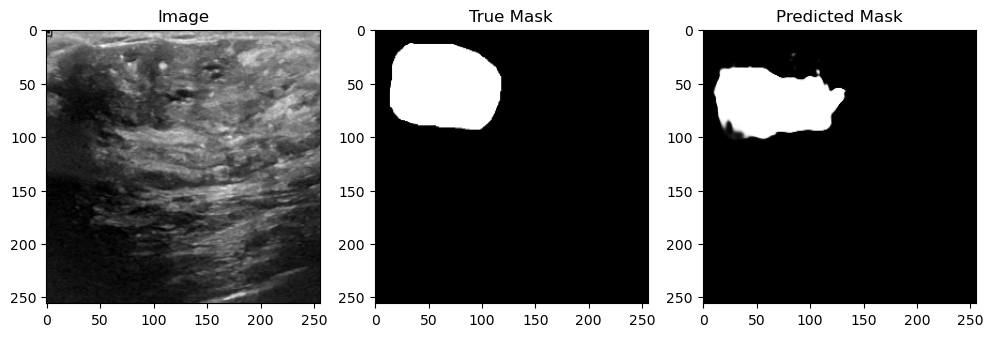

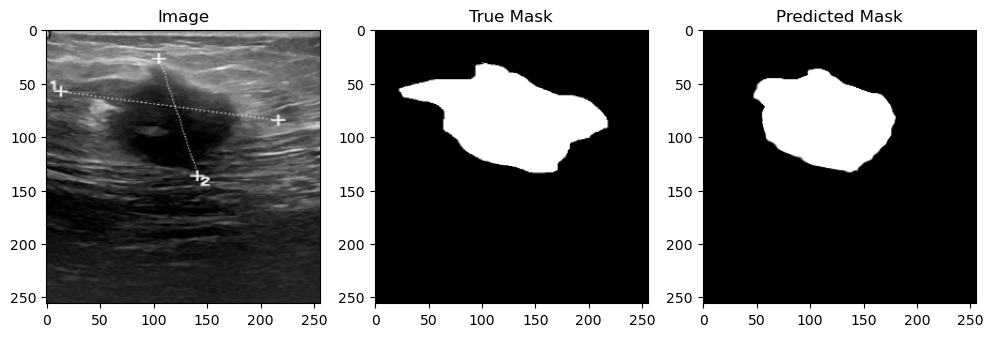

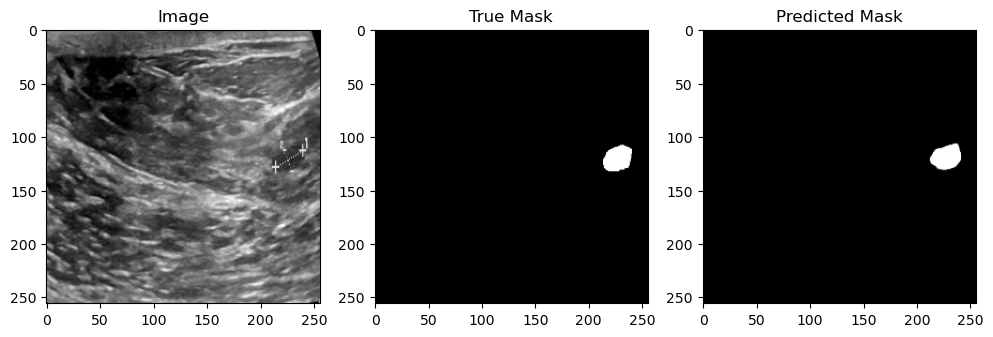

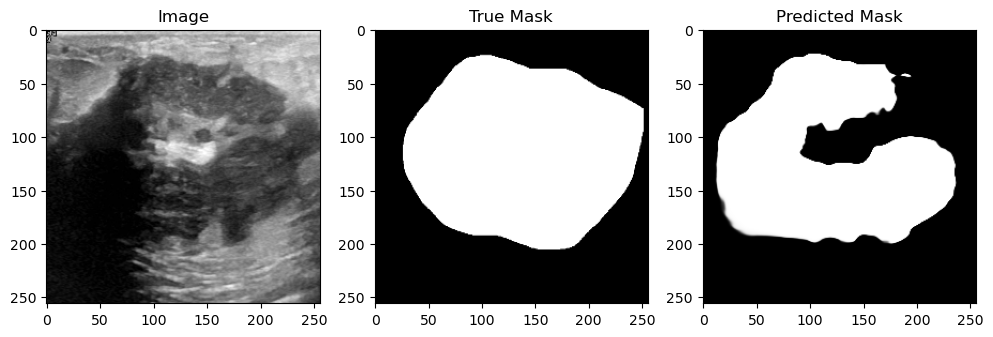

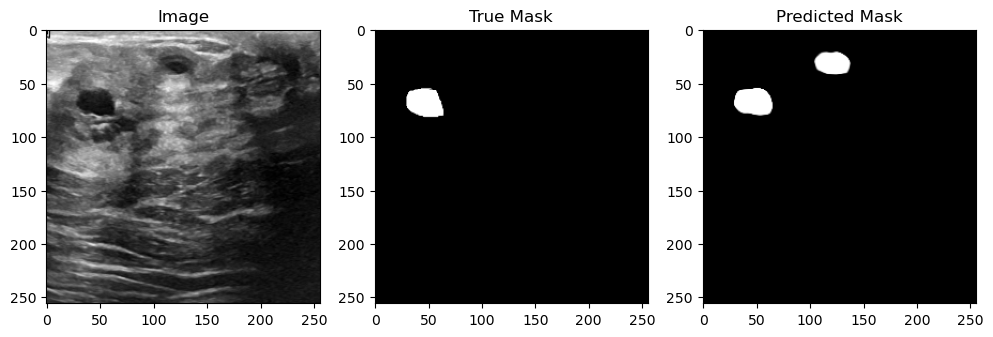

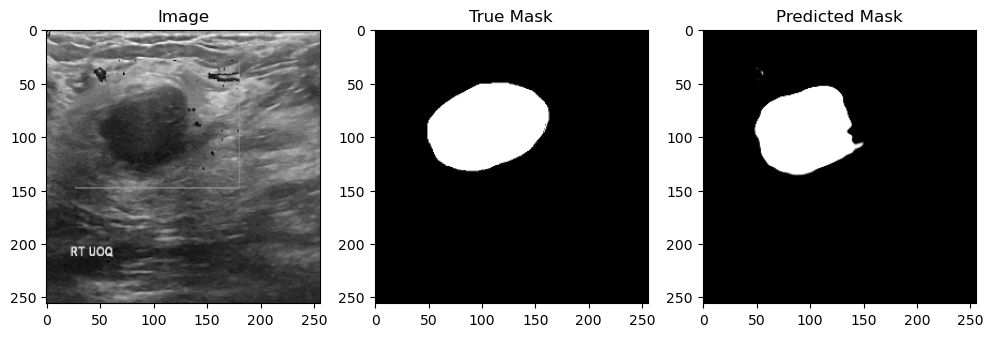

In [14]:
# select 10 random images from the test set
indices = np.random.choice(len(test_images), 10)

# visualize the images, ground truth masks, and predicted masks
for i, index in enumerate(indices):
    # select the i-th image, ground truth mask, and predicted mask
    image = test_images[index]
    true_mask = test_masks[index]
    pred_mask = predicted_masks[index]

    # plot the image and masks
    fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(true_mask.squeeze(), cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask.squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    plt.show()